<h1>PakCar Valuator: Predicting Vehicle Prices in Pakistan</h1>
<h3>Syed Muhammad Hamza Ali</h3>

### DATA WRANGLING

In [1]:
# importing Libraries

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [2]:
# reading the dataset

df=pd.read_csv('pakwheels.csv') 
df.head()

,Ad No,Name,Model Year,Mileage,Engine Capacity,Engine Type,Registered City,Transmission,Price,Last Updated
0,8126173,Toyota Surf SSR-X 4.0 2004,2004,93000,4000 cc,Petrol,NaN,Automatic,7900000.0,"Dec 14, 2023"
1,8191736,Honda City 1.3 i-VTEC 2013,2013,79000,1300 cc,Petrol,NaN,Manual,2630000.0,"Dec 14, 2023"
2,8098706,Toyota Corolla Axio Hybrid 1.5 2014,2014,82000,1500 cc,Hybrid,NaN,Automatic,4900000.0,"Dec 14, 2023"
3,8134721,Toyota Prado TX 2.7 2018,2018,14000,2700 cc,Petrol,NaN,Automatic,27000000.0,"Dec 14, 2023"
4,8191739,Toyota Passo Moda G 2020,2020,6700,1000 cc,Petrol,NaN,Automatic,5500000.0,"Dec 14, 2023"


In [3]:
# selecting features to work on

df_car=df[['Name', 'Model Year', 'Mileage', 'Engine Capacity', 'Engine Type', 'Transmission', 'Price']]
df_car

,Name,Model Year,Mileage,Engine Capacity,Engine Type,Transmission,Price
0,Toyota Surf SSR-X 4.0 2004,2004,93000,4000 cc,Petrol,Automatic,7900000.0
1,Honda City 1.3 i-VTEC 2013,2013,79000,1300 cc,Petrol,Manual,2630000.0
2,Toyota Corolla Axio Hybrid 1.5 2014,2014,82000,1500 cc,Hybrid,Automatic,4900000.0
3,Toyota Prado TX 2.7 2018,2018,14000,2700 cc,Petrol,Automatic,27000000.0
4,Toyota Passo Moda G 2020,2020,6700,1000 cc,Petrol,Automatic,5500000.0
...,...,...,...,...,...,...,...
59812,Toyota Corolla Altis Grande X CVT-i 1.8 Beige ...,2022,12000,1799 cc,Petrol,Automatic,7050000.0
59813,Suzuki Cultus VXL 2017,2017,68000,1000 cc,Petrol,Manual,2500000.0
59814,Toyota Passo X L Package S 2017,2017,60000,1000 cc,Petrol,Automatic,3650000.0
59815,Toyota Corolla GLi Automatic 1.3 VVTi 2015,2015,150000,1300 cc,Petrol,Automatic,3350000.0


#### HANDLING NAME FEATURE

In [4]:
# Split the name into Make Model and variant features

df_car = df_car.copy() # used this to remove the SettingWithCopyWarning

df_car['name_split'] = df_car['Name'].str.split()

# Extract 'Make', 'Model', and 'Variant' from the split words:
df_car['Make'] = df_car['name_split'].apply(lambda x: x[0])
df_car['Model'] = df_car['name_split'].apply(lambda x: x[1])
df_car['Variant'] = df_car['name_split'].apply(lambda x: " ".join(x[2:-1]))

# Drop the temporary 'name_split' column and the original 'Name' column:
df_car = df_car.drop('name_split', axis=1)
df_car = df_car.drop('Name', axis=1)

#### HANDLING MAKE FEATURE

In [5]:
'''
Upon dividing the name feature, we identified distinct Make, Model, and Vairiant features.
However, this approach caused an unintended consequence: certain car brands like Range Rover,
Land Rover, and Mercedes Benz were inadvertently broken up, with their complete names scattered
across different features. To address this, this additional handling was implemented 
'''

# Handling the Range Rover make
range_rover_make = df_car[df_car.Make == 'Range'].copy()
range_rover_make.Make = 'Range Rover'
range_rover_make.Model = range_rover_make.Variant.str.split().apply(lambda x: x[0])
range_rover_make.Variant = range_rover_make.Variant.str.split().apply(lambda x: " ".join(x[1:]))

# Handling the Land Rover make
land_make = df_car[df_car.Make == 'Land'].copy()
land_make.Make = 'Land Rover'
land_make.Model = land_make.Variant.str.split().apply(lambda x: x[0])
land_make.Variant = land_make.Variant.str.split().apply(lambda x: " ".join(x[1:]))

# Handling the Mercedez Benz make
mercedes_make = df_car[df_car.Make == 'Mercedes'].copy()
mercedes_make.Make = 'Mercedes Benz'
mercedes_make.Model = mercedes_make.Variant.str.split().apply(lambda x: " ".join(x[:2]))
mercedes_make.Variant = mercedes_make.Variant.str.split().apply(lambda x: " ".join(x[2:]))

# concating the results in the dataset
df_car.loc[(df_car.Make=='Land')] = land_make
df_car.loc[(df_car.Make=='Range')] = range_rover_make
df_car.loc[(df_car.Make=='Mercedes')] = mercedes_make

# df_car = pd.concat([df_car[df_car.Make != 'Land'], land_make], ignore_index=True)
# df_car = pd.concat([df_car[df_car.Make != 'Range'], range_rover_make], ignore_index=True)
# df_car = pd.concat([df_car[df_car.Make != 'Mercedes'], mercedes_make], ignore_index=True)


#### HANDLING MODEL AND VARIANT FEATURE

In [6]:
'''
We also encountered certain models represented by partial names within the 
"Model" and "Variant" features. To ensure complete and accurate representation,
we implemented dedicatedd handling for these models
'''

# Handling the BMW Models
bmw_model = df_car[df_car['Model'].isin(['1', '2', '3', '5', '7'])].copy() 
bmw_model['Model'] = bmw_model.apply(lambda row: row['Model'] + ' ' + row['Variant'].split()[0], axis=1)
bmw_model['Variant'] = bmw_model.apply(lambda row: ' '.join(row['Variant'].split()[1:]), axis=1)

# Handling the Land Cruiser Model
landCruiser_model = df_car[df_car.Model == 'Land'].copy()
landCruiser_model['Model'] = landCruiser_model.apply(lambda row: row['Model'] + ' ' + row['Variant'].split()[0], axis=1)
landCruiser_model['Variant'] = landCruiser_model.apply(lambda row: ' '.join(row['Variant'].split()[1:]), axis=1)

# Handling the Wagon R Model
WagonR_model = df_car[df_car.Model == 'Wagon'].copy()
WagonR_model['Model'] = WagonR_model.apply(lambda row: row['Model'] + ' ' + row['Variant'].split()[0], axis=1)
WagonR_model['Variant'] = WagonR_model.apply(lambda row: ' '.join(row['Variant'].split()[1:]), axis=1)

# Handling the Honda N Wagon Model
NWgn_model = df_car[df_car.Model == 'N'].copy()
NWgn_model['Model'] = NWgn_model.apply(lambda row: row['Model'] + ' ' + row['Variant'].split()[0], axis=1)
NWgn_model['Variant'] = NWgn_model.apply(lambda row: ' '.join(row['Variant'].split()[1:]), axis=1)

# Handling Nissan BlueBird Model:
BlueBird_model = df_car[df_car.Model == 'Blue'].copy()
BlueBird_model['Model'] = BlueBird_model.apply(lambda row: row['Model'] + ' ' + row['Variant'].split()[0], axis=1)
BlueBird_model['Variant'] = BlueBird_model.apply(lambda row: ' '.join(row['Variant'].split()[1:]), axis=1)

# Handling Toyota Mark Model:
MarkX_model = df_car[df_car.Model == 'Mark'].copy()
MarkX_model['Model'] = MarkX_model.apply(lambda row: row['Model'] + ' ' + row['Variant'].split()[0], axis=1)
MarkX_model['Variant'] = MarkX_model.apply(lambda row: ' '.join(row['Variant'].split()[1:]), axis=1)

# Handling Lexus LX Model:
LexusLX_model = df_car[df_car.Model == 'LX'].copy()
LexusLX_model['Model'] = LexusLX_model.apply(lambda row: row['Model'] + ' ' + row['Variant'].split()[0], axis=1)
LexusLX_model['Variant'] = LexusLX_model.apply(lambda row: ' '.join(row['Variant'].split()[1:]), axis=1)

# Concatinating the results in the dataset
df_car.loc[df_car['Model'].isin(['1', '2', '3', '5', '7']) & (df_car['Make'] == 'BMW')] = bmw_model
df_car.loc[(df_car['Model'] == 'Land') & (df_car['Make'] == 'Toyota')] = landCruiser_model
df_car.loc[(df_car['Model'] == 'Wagon') & (df_car['Make'] == 'Suzuki')] = WagonR_model
df_car.loc[(df_car['Model'] == 'N') & (df_car['Make'] == 'Honda')] = NWgn_model
df_car.loc[(df_car['Model'] == 'Blue') & (df_car['Make'] == 'Nissan')] = BlueBird_model
df_car.loc[(df_car['Model'] == 'Mark') & (df_car['Make'] == 'Toyota')] = MarkX_model
df_car.loc[(df_car['Model'] == 'LX') & (df_car['Make'] == 'Lexus')] = LexusLX_model

#### HANDLING YEAR FEATURE

In [7]:
# Rename the 'Model Year' column to 'Year':
df_car = df_car.rename(columns={'Model Year': 'Year'})

# Define the new order for features:
new_order = ['Make', 'Model', 'Variant', 'Year', 'Mileage', 'Engine Capacity', 'Engine Type', 'Transmission', 'Price']

# Reorder the DataFrame columns based on the new order:
df_car = df_car[new_order]

#### HANDLING MILEAGE FEATURE

<Axes: xlabel='Mileage'>

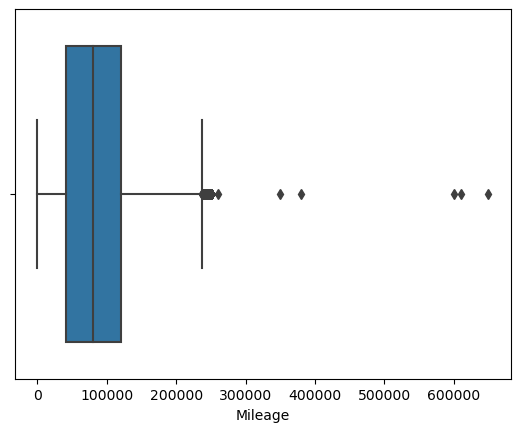

In [8]:
'''
-> Applied constraints to ensure data consistency:
    For year <= 2020: mileage must be within [2500, 250000]
    For year > 2020: no mileage restrictions
-> Removed rows violating these constraints
-> Visualized filtered data with a boxplot for oulier detection
'''

df_car = df_car[ ((df_car['Year'] <= 2020) & (df_car['Mileage'] >= 2500) & 
                  (df_car['Mileage'] <= 250000)) | (df_car['Year'] > 2020)]

# Displaying a boxplot to visualize the distribution and identify outliers:
sns.boxplot(data=df_car, x='Mileage')

<Axes: xlabel='Mileage'>

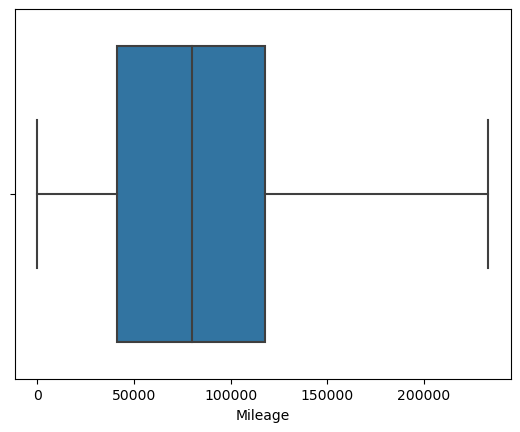

In [9]:
# Calculate the quartiles and IQR for the 'Mileage' feature:
Q1 = df_car['Mileage'].quantile(0.25)
Q3 = df_car['Mileage'].quantile(0.75)
IQR = Q3 - Q1

# Define the acceptable range for Mileage using the IQR method:
_min = Q1 - 1.5 * IQR
_max = Q3 + 1.5 * IQR

# Filter the DataFrame to exclude outliers based on the defined range:
df_car = df_car[(df_car['Mileage'] > _min) & (df_car['Mileage'] < _max)]

'''
After the first attempt to clean the outliers, there were still some outliers left,
so we will apply the IQR technique again to remove all the remaining ones as well
'''

Q1 = df_car['Mileage'].quantile(0.25)
Q3 = df_car['Mileage'].quantile(0.75)
IQR = Q3 - Q1

_min = Q1 - 1.5 * IQR
_max = Q3 + 1.5 * IQR

df_car = df_car[(df_car['Mileage'] > _min) & (df_car['Mileage'] < _max)]

# Display a boxplot to verify the removal of outliers:
sns.boxplot(data=df_car, x='Mileage')

#### HANDLING ENGINE CAPACITY FEATURE

In [10]:
'''
-> Remove the ' cc ' from Engine Capacity feature and convert it to integers.
-> Remove/Impute Data Entry Errors.
-> Imputing the NaN values with the values from Engine Capacity of the same Make and Model.
-> Round the values to the nearest multiple of 10.
-> Remove all the NaN values (mostly were of electric vehicles).
-> Remove all data entry errors as well

Note: This model does not account for fully electric vehicles.
'''

df_car['Engine Capacity'] = pd.to_numeric(df_car['Engine Capacity'].str.replace(' cc', ''))
df_car = df_car.copy()
df_car = df_car.dropna(subset=['Engine Capacity'])


# Create a copy of the DataFrame for modifications:
df_2 = df_car.copy()

# Set NaN for all vehicles with 'Engine Capacity' outside the reasonable range:
df_2.loc[(df_2['Engine Capacity'] < 600) | (df_2['Engine Capacity'] > 6700), 'Engine Capacity'] = np.NaN

# Identify rows where all values match except for 'Engine Capacity':
matching_rows = df_2.drop(columns=['Engine Capacity']).eq(df_car.drop(columns=['Engine Capacity'])).all(axis=1)

# Replace corresponding rows in df_car with modified rows from df_2:
df_car.loc[matching_rows, 'Engine Capacity'] = df_2.loc[matching_rows, 'Engine Capacity']

# Handle NaN values by filling them with values from 'Engine Capacity' of the same Make and Model:
df_car['Engine Capacity'] = df_car.groupby(['Make', 'Model'])['Engine Capacity'].transform(lambda x: x.fillna(method='bfill'))

# Drop all remaining rows with NaN values:
df_car = df_car.dropna()

# Round off the values of 'Engine Capacity' to the nearest full multiple of 10:
df_car['Engine Capacity'] = df_car['Engine Capacity'].round(-1)

# Convert 'Engine Capacity' to integer data type:
df_car['Engine Capacity'] = df_car['Engine Capacity'].astype(int)

#### HANDLING ENGINE TYPE FEATURE

In [11]:
'''
Engine Type has null values.
    Handling those NaN values by imputing the data with the values 
    from Engine Type of the same Make and Model.
Drop all the remaining rows with NaN.
'''

df_car['Engine Type'] = df_car.groupby(['Make', 'Model'])['Engine Type'].transform(lambda x: x.fillna(method='ffill'))
df_car = df_car.dropna()

#### HANDLING PRICE FEATURE

<Axes: xlabel='Price'>

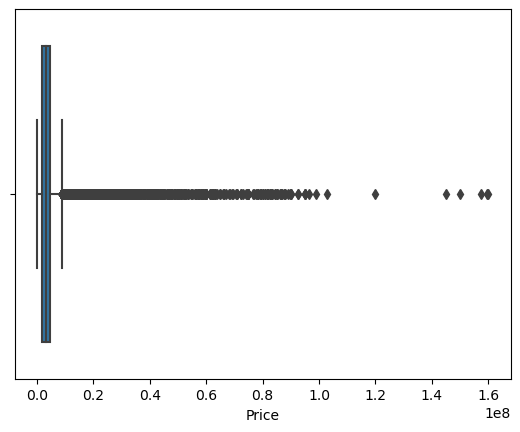

In [12]:
'''
Handling 'Call for Price' and other non-numeric values from Price prediction
   -> Remove the rows with 'Call for Price'
   -> Remove any non-numeric character from the feature
   
   -> After checking for typos, there are 3 rows that needed to be handled
   -> Placing a logical check that the price > 200K
'''

df_car = df_car.copy()

df_car = df_car[df_car['Price'] != 'Call for price']

df_car['Price'] = df_car['Price'].replace('[^\d.]', '', regex=True).astype(float).astype(int)

# Drop selected rows with incorrect prices (potential typos):
df_car = df_car.drop([1697, 21648, 45815])

# Remove rows with price less than 200K and reset the index:
df_car = df_car[df_car['Price'] >= 200000].reset_index(drop=True)

# Display a boxplot to visualize the distribution of prices:
sns.boxplot(data=df_car, x='Price')

There are a lot of Outliers when checked with the boxplot but after cafeful consideration, the vehicles justifies the price and therefore can not be considered as an outlier. In short, there are no Outliers in this feature.

#### GENERAL INFORMATION

In [13]:
print('Shape of Data Before Data Wrangling:', df.shape)
print('Shape of Data After Data Wrangling:', df_car.shape)
print()
print('Difference between Before and After:', df.shape[0] - df_car.shape[0])

Shape of Data Before Data Wrangling: (59817, 10)
Shape of Data After Data Wrangling: (54984, 9)

Difference between Before and After: 4833


In [14]:
df_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54984 entries, 0 to 54983
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Make             54984 non-null  object
 1   Model            54984 non-null  object
 2   Variant          54984 non-null  object
 3   Year             54984 non-null  int64 
 4   Mileage          54984 non-null  int64 
 5   Engine Capacity  54984 non-null  int32 
 6   Engine Type      54984 non-null  object
 7   Transmission     54984 non-null  object
 8   Price            54984 non-null  int32 
dtypes: int32(2), int64(2), object(5)
memory usage: 3.4+ MB


In [15]:
df_car.describe()

,Year,Mileage,Engine Capacity,Price
count,54984.000000,54984.000000,54984.000000,5.498400e+04
mean,2013.906136,83962.572257,1408.496108,4.178257e+06
std,6.968146,52103.896708,681.354857,5.589767e+06
min,1990.000000,1.000000,600.000000,2.000000e+05
25%,2010.000000,42000.000000,1000.000000,1.850000e+06
50%,2016.000000,80000.000000,1300.000000,3.100000e+06
75%,2019.000000,118000.000000,1600.000000,4.700000e+06
max,2022.000000,233409.000000,6600.000000,1.600000e+08


#### SAVING THE CLEANED DATASET

In [16]:
df_car.to_csv('CleanedPakWheels.csv', index=False)

-------------------------------------------------------------------------------------------------------------------------------

### MODEL TRAINING AND TESTING

In [17]:
# Import necessary libraries

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [18]:
# read the cleaned dataset

data=pd.read_csv('CleanedPakWheels.csv')

In [19]:
# Defining independant features (X) and target variable (y)

X = data.drop('Price', axis=1)
y = data['Price']

In [20]:
# splitting dataset into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)

In [21]:
numeric_features = ['Year', 'Mileage', 'Engine Capacity']
categorical_features = ['Make', 'Model', 'Variant', 'Engine Type', 'Transmission']

# Create a pipeline for numeric feature transformation (scaling):
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create a pipeline for categorical feature transformation (one-hot encoding):
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine numeric and categorical transformers into a single ColumnTransformer:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

#### MODEL 1 - Linear Regression Model

In [22]:
# Create a pipeline for the linear regression model, incorporating the previously defined preprocessor:
linear_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the linear regression model on the training data:
linear_model.fit(X_train, y_train)

# Make predictions on the test data using the trained model:
linear_predictions = linear_model.predict(X_test)

# Evaluate the linear regression model using various metrics:
linear_mae = mean_absolute_error(y_test, linear_predictions)
linear_mse = mean_squared_error(y_test, linear_predictions)
linear_r2 = r2_score(y_test, linear_predictions)

# Print the metrics for linear regression model evaluation:
print('Linear Regression Metrics:')
print(f'Mean Absolute Error: {linear_mae}')
print(f'Mean Squared Error: {linear_mse}')
print(f'R-squared: {linear_r2}')

Linear Regression Metrics:
Mean Absolute Error: 742825.6341412525
Mean Squared Error: 10558350352630.3
R-squared: 0.6946430829592273


#### MODEL 2 - Decision Tree Model

In [23]:
# Create a pipeline for the decision tree regression model, incorporating the previously defined preprocessor:
decision_tree_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=26))
])

# Fit the decision tree regression model on the training data:
decision_tree_model.fit(X_train, y_train)

# Make predictions on the test data using the trained model:
decision_tree_predictions = decision_tree_model.predict(X_test)

# Evaluate the decision tree regression model using various metrics:
dt_mae = mean_absolute_error(y_test, decision_tree_predictions)
dt_mse = mean_squared_error(y_test, decision_tree_predictions)
dt_r2 = r2_score(y_test, decision_tree_predictions)

# Print the metrics for decision tree regression model evaluation:
print('Decision Tree Metrics:')
print(f'Mean Absolute Error: {dt_mae}')
print(f'Mean Squared Error: {dt_mse}')
print(f'R-squared: {dt_r2}')

Decision Tree Metrics:
Mean Absolute Error: 448053.2784591584
Mean Squared Error: 2758935622566.5146
R-squared: 0.9202091190494543


#### MODEL 3 - eXtreme Gradiant Boosting Model (XGBoost)

XGBoost is a powerful machine learning algorithm known for its efficiency and accuracy. It utilizes an ensemble of decision trees with regularization to prevent overfitting, making it effective in capturing complex relationships within data. In car price prediction projects, XGBoost's ability to handle non-linearity, efficiently process large datasets, and provide insights into feature importance makes it a popular choice for achieving accurate and robust predictions.

In [24]:
# Create a pipeline for the XGBoost regression model, incorporating the previously defined preprocessor:
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=26))
])

# Fit the XGBoost regression model on the training data:
xgb_model.fit(X_train, y_train)

# Make predictions on the test data using the trained model:
xgb_predictions = xgb_model.predict(X_test)

# Evaluate the XGBoost regression model using various metrics:
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

# Print the metrics for XGBoost regression model evaluation:
print('XGBoost Metrics:')
print(f'Mean Absolute Error: {xgb_mae}')
print(f'Mean Squared Error: {xgb_mse}')
print(f'R-squared: {xgb_r2}')

XGBoost Metrics:
Mean Absolute Error: 424358.5083048218
Mean Squared Error: 1360031035991.1155
R-squared: 0.9606666884162869


#### MODEL 4 - Light Gradiant Boosting Model (LGBM)

LightGBM is another gradient boosting framework like XGBoost, designed for efficiency and speed. It employs a tree-based learning approach and is particularly suitable for large datasets. LightGBM is known for its ability to handle categorical features efficiently, making it valuable in projects such as car price prediction where diverse types of features play a role. Its fast training speed and low memory usage contribute to its popularity, especially when dealing with extensive datasets and when quick model deployment is crucial.

In [25]:
# Create a pipeline for the LightGBM regression model, incorporating the previously defined preprocessor:
lgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(random_state=26))
])

# Fit the LightGBM regression model on the training data:
lgb_model.fit(X_train, y_train)

# Make predictions on the test data using the trained model:
lgb_predictions = lgb_model.predict(X_test)

# Evaluate the LightGBM regression model using various metrics:
lgb_mae = mean_absolute_error(y_test, lgb_predictions)
lgb_mse = mean_squared_error(y_test, lgb_predictions)
lgb_r2 = r2_score(y_test, lgb_predictions)

# Print the metrics for LightGBM regression model evaluation:
print('LightGBM Metrics:')
print(f'Mean Absolute Error: {lgb_mae}')
print(f'Mean Squared Error: {lgb_mse}')
print(f'R-squared: {lgb_r2}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 43987, number of used features: 462
[LightGBM] [Info] Start training from score 4169251.276582
LightGBM Metrics:
Mean Absolute Error: 456811.6219293248
Mean Squared Error: 2451209441574.4023
R-squared: 0.9291088348935184


#### MODEL COMPARISON

In [26]:
metrics = {
    'Model': ['Linear Regression', 'Decision Tree', 'XGBoost', 'LightGBM'],
    'MAE': [linear_mae, dt_mae, xgb_mae, lgb_mae],
    'MSE': [linear_mse, dt_mse, xgb_mse, lgb_mse],
    'R2': [linear_r2, dt_r2, xgb_r2, lgb_r2]
}

# Define a custom float format function
def float_format(x):
    return f'{x:.6f}'

# Create the DataFrame with custom float formatting
df_metrics = pd.DataFrame(metrics).set_index('Model').applymap(float_format)
df_metrics

,MAE,MSE,R2
Model,,,
Linear Regression,742825.634141,10558350352630.300781,0.694643
Decision Tree,448053.278459,2758935622566.514648,0.920209
XGBoost,424358.508305,1360031035991.115479,0.960667
LightGBM,456811.621929,2451209441574.402344,0.929109


-------------------------------------------------------------------------------------------------------------------------------

### MODEL TESTING

In [27]:
# Read the test dataset from the CSV file:
df = pd.read_csv('test_.csv')

# Separate features (X) and target variable (y) in the test dataset:
X = df.drop(['Price'], axis=1)
y = df['Price']

# Make predictions using the trained models on the test dataset:
linear_pred = linear_model.predict(df).astype(int)
dct_pred = decision_tree_model.predict(df).astype(int)
xgb_pred = xgb_model.predict(df).astype(int)
lgbm_pred = lgb_model.predict(df).astype(int)

# Create a DataFrame with the predicted prices from each model:
df_predictions = pd.DataFrame({
    'Linear Predicted Price': linear_pred,
    'DCT Predicted Price': dct_pred,
    'XGB Predicted Price': xgb_pred,
    'LGBM Predicted Price': lgbm_pred
})

# Concatenate the original test dataset with the predicted prices:
df = pd.concat([df, df_predictions], axis=1)

<Figure size 2000x1000 with 0 Axes>

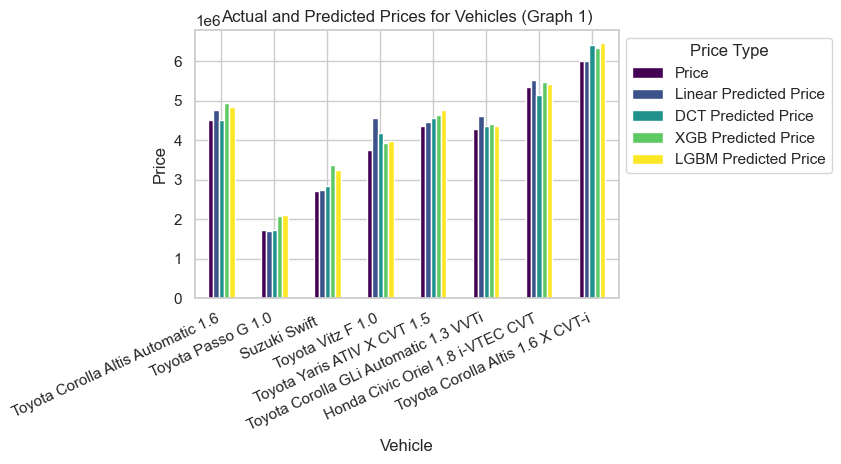

<Figure size 2000x1000 with 0 Axes>

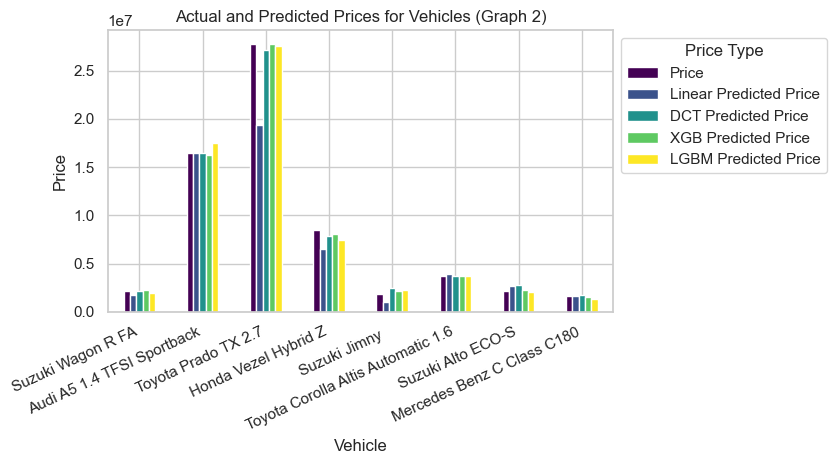

<Figure size 2000x1000 with 0 Axes>

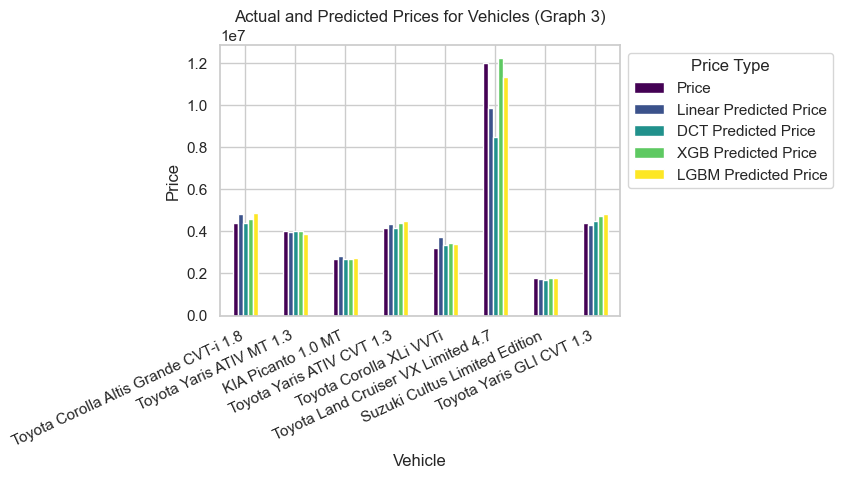

<Figure size 2000x1000 with 0 Axes>

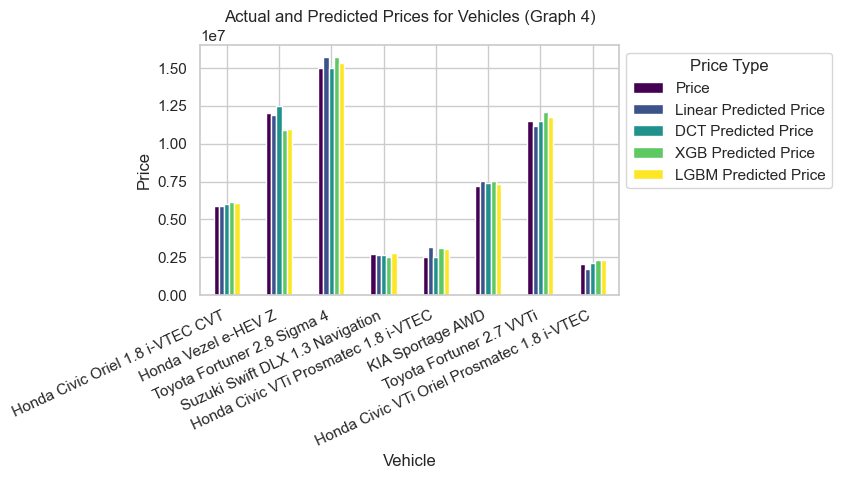

<Figure size 2000x1000 with 0 Axes>

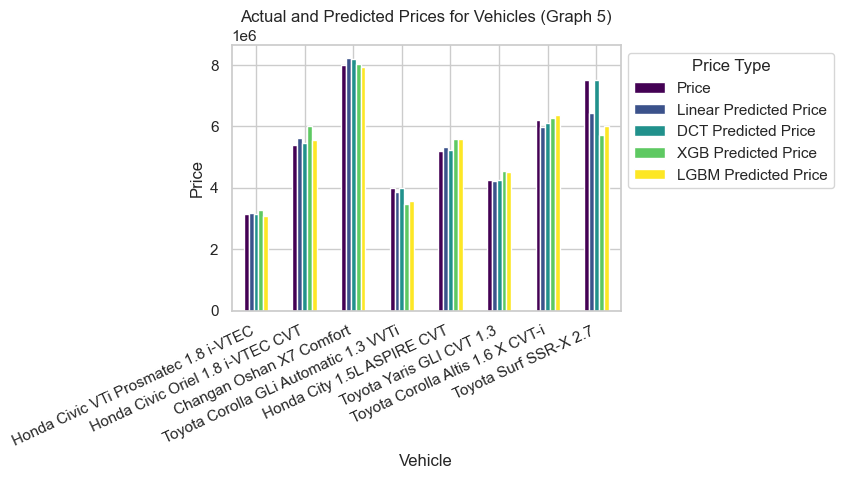

<Figure size 2000x1000 with 0 Axes>

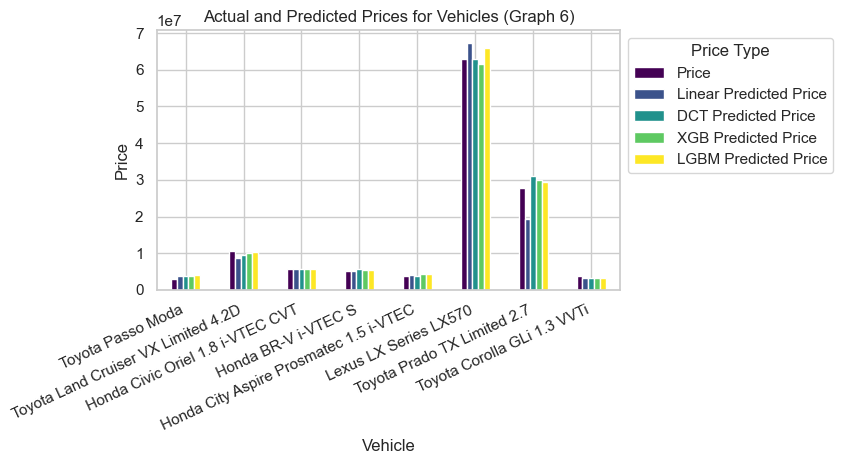

<Figure size 2000x1000 with 0 Axes>

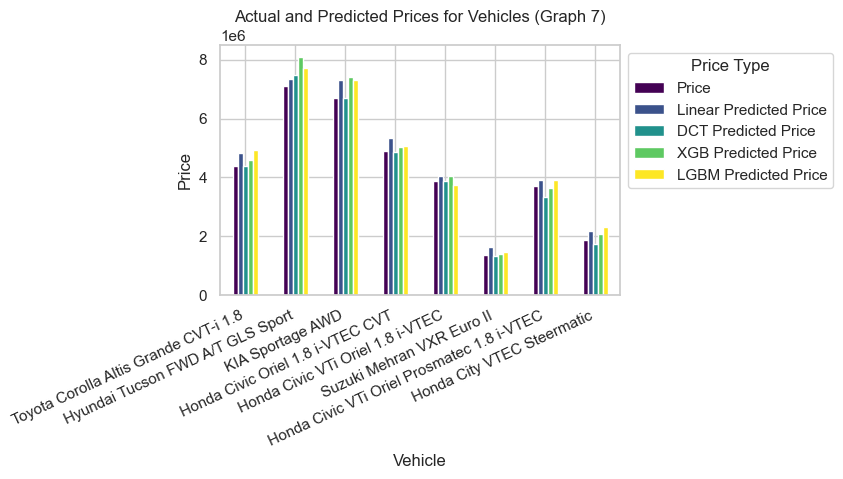

In [30]:
# Combine 'Make', 'Model', and 'Variant' into one string
df_predictions['Vehicle'] = df['Make'] + ' ' + df['Model'] + ' ' + df['Variant']
df_predictions['Price'] = df['Price']

# Select relevant columns for plotting
columns_to_plot = ['Vehicle', 'Price', 'Linear Predicted Price', 'DCT Predicted Price', 'XGB Predicted Price', 'LGBM Predicted Price']
df_plot = df_predictions[columns_to_plot]

# Set 'Vehicle' as the index for plotting
df_plot.set_index('Vehicle', inplace=True)

# Number of vehicles per graph
vehicles_per_graph = 8

# Calculate the number of graphs needed
num_graphs = len(df_plot) // vehicles_per_graph
if len(df_plot) % vehicles_per_graph != 0:
    num_graphs += 1

# Set the style for seaborn
sns.set(style="whitegrid")

# Plotting using seaborn
for i in range(num_graphs):
    start_idx = i * vehicles_per_graph
    end_idx = (i + 1) * vehicles_per_graph

    # Create a new figure and subplot for each group of 8 vehicles
    plt.figure(figsize=(20, 10))
    ax = df_plot.iloc[start_idx:end_idx].plot(kind='bar', stacked=False, colormap='viridis')
    plt.ylabel('Price')
    plt.title(f'Actual and Predicted Prices for Vehicles (Graph {i + 1})')
    plt.xticks(rotation=25, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()

    # Add legend with labels for each bar type
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, title="Price Type", loc="upper left", bbox_to_anchor=(1, 1))

    plt.show()

------------------------------------------------------------------------------------------------------------------------------

### SAVE MODELS

In [29]:
import pickle

pickle.dump(linear_model, open('linear_model.pkl', 'wb'))
pickle.dump(decision_tree_model, open('decision_tree_model.pkl', 'wb'))
pickle.dump(xgb_model, open('xgb_model.pkl', 'wb'))
pickle.dump(lgb_model, open('lgb_model.pkl', 'wb'))